In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
def show_tables():
    q = "SELECT name, type FROM sqlite_master WHERE type IN ('table','view');"
    print(run_query(q))
show_tables()

              name   type
0            album  table
1           artist  table
2         customer  table
3         employee  table
4            genre  table
5          invoice  table
6     invoice_line  table
7       media_type  table
8         playlist  table
9   playlist_track  table
10           track  table


task: to determine what genre sell the most tracks in the USA

In [2]:
q1="""
WITH usa AS
(SELECT customer_id
FROM customer
WHERE country = "USA"),
usa_track AS
(SELECT t.genre_id, t.track_id
FROM track t
INNER JOIN invoice_line il ON il.track_id = t.track_id
INNER JOIN invoice i ON i.invoice_id = il.invoice_id
INNER JOIN usa ON usa.customer_id=i.customer_id)
SELECT g.name genre, COUNT(ut.track_id) n_tracks_sold,
CAST(COUNT(ut.track_id) AS FLOAT) / (SELECT COUNT(*) FROM usa_track) percentage
FROM genre g
LEFT JOIN usa_track ut ON g.genre_id = ut.genre_id
GROUP BY 1
ORDER BY 2 DESC
"""
run_query(q1)

,genre,n_tracks_sold,percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


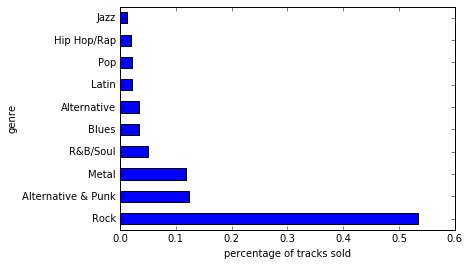

In [3]:
genre_track = run_query(q1)
genre_track.set_index("genre", drop = True, inplace = True)
genre_track.iloc[0:10, 1].plot.barh()
plt.xlabel("percentage of tracks sold")
plt.show()

task: to find out which sales support agent performed best.

In [4]:
run_query("select first_name, last_name from employee where title='Sales Support Agent'")

,first_name,last_name
0,Jane,Peacock
1,Margaret,Park
2,Steve,Johnson


In [5]:
q2 = """
SELECT 
    e.first_name || " " || e.last_name sales_name,
    COUNT(DISTINCT(c.customer_id)) n_customer,
    SUM(i.total) sales_amount,
    COUNT(il.track_id) n_tracks
FROM employee e
LEFT JOIN customer c ON e.employee_id = c.support_rep_id
LEFT JOIN invoice i ON c.customer_id = i.customer_id
LEFT JOIN invoice_line il ON i.invoice_id = il.invoice_id
WHERE e.title = "Sales Support Agent"
GROUP BY 1
"""
run_query(q2)

,sales_name,n_customer,sales_amount,n_tracks
0,Jane Peacock,21,18246.69,1749
1,Margaret Park,20,15923.16,1600
2,Steve Johnson,18,13333.32,1408


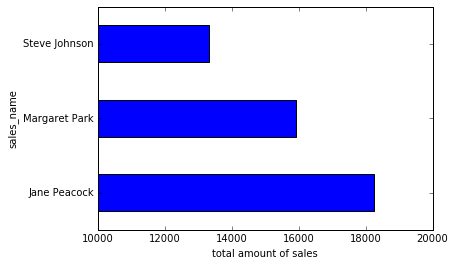

In [6]:
sales_performance = run_query(q2)
sales_performance.set_index("sales_name", drop=True, inplace=True)
sales_performance["sales_amount"].plot.barh()
plt.xlim(xmin=10000)
plt.xlabel("total amount of sales")
plt.show()

Jane Peacock performed the best among the 3 sales support agent in the company based on number of customers, total dollar amount of sales and number of tracks sold.

task: to analyze the sales data for customers from each different country.

In [7]:
q3 = """
WITH customer_country AS
    (
    SELECT 
        c.country,
        COUNT(DISTINCT(i.customer_id)) c_count,
        SUM(i.total) total_sales,
        CAST(SUM(i.total) AS FLOAT)/COUNT(DISTINCT(i.customer_id)) sale_per_customer,
        AVG(i.total) avg_order
    FROM customer c
    INNER JOIN invoice i ON i.customer_id=c.customer_id
    GROUP BY 1
    ORDER BY 2 DESC
    ),
cc_info AS
    (
    SELECT
        country_r country,
        sum(c_count) customer_count,
        sum(total_sales) total_sales,
        AVG(sale_per_customer) sale_per_customer,
        AVG(avg_order) avg_order    
    FROM
        (
         SELECT
             cc.*,
             CASE
                 WHEN cc.c_count = 1 THEN 'other'
                 ELSE country
             END AS country_r
         FROM customer_country cc
         )
     GROUP BY 1
     ORDER BY 3 DESC
     )
SELECT *
FROM
    (
     SELECT *,
         CASE
             WHEN country='other' THEN 0.1
             ELSE 0
         END AS sort
     FROM cc_info
     )
ORDER BY sort
"""
run_query(q3)


,country,customer_count,total_sales,sale_per_customer,avg_order,sort
0,USA,13,1040.49,80.037692,7.942672,0.0
1,Canada,8,535.59,66.948750,7.047237,0.0
2,Brazil,5,427.68,85.536000,7.011148,0.0
3,France,5,389.07,77.814000,7.781400,0.0
4,Germany,4,334.62,83.655000,8.161463,0.0
5,Czech Republic,2,273.24,136.620000,9.108000,0.0
6,United Kingdom,3,245.52,81.840000,8.768571,0.0
7,Portugal,2,185.13,92.565000,6.383793,0.0
8,India,2,183.15,91.575000,8.721429,0.0
9,other,15,1094.94,72.996000,7.445071,0.1


In [8]:
import seaborn as sns
import numpy as np
sales_by_country = run_query(q3)
df = sales_by_country.set_index('country',drop=False,inplace=False)
n=len(df['country'])
fig1, ax1 = plt.subplots()
ax1.pie(df['customer_count'], explode=df['sort'], labels=df['country'],autopct='%1.1f%%',startangle=90, colors=sns.color_palette("Set2", n))
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Distribution of customer counts among the countries')

fig2, ax2 =plt.subplots()
ax2 = df['total_sales'].plot(kind='barh',title='total sales amount across different countries',color=sns.color_palette("Set2", n))
ax2.set_xlabel('total $ sales amount')

fig3, ax3 =plt.subplots()
ax3 = df['sale_per_customer'].plot(kind='barh',title='average sale per customer across different countries',color=sns.color_palette("Set2", n))
ax3.set_xlabel('average $ sales amount')

fig4, ax4 =plt.subplots()
ax4 = df['avg_order'].plot(kind='barh',title='average order amount across different countries',color=sns.color_palette("Set2", n))
ax4.set_xlabel('average $ sales amount')
plt.show()

NameError: name 'q3' is not defined

Czech Republic has highest sale amount per customer. Therefore it is recommended to run adversting campaign to promote the store/brand awareness and accumulate more customers in order to increase sales and revenues.
United Kingdom and India have relatively high amount of sales per order. It is recommended to run adversting campaign on new tracks/albums in these countries to increase sales.

task 4: to find out what percentage of purchases are individual tracks vs. whole albums.

In [23]:
q4="""
WITH invoice_track AS
    (
     SELECT
         il.invoice_id,
         il.track_id,
         t.album_id
     FROM invoice_line il
     INNER JOIN track t ON t.track_id=il.track_id
    ),
album_track AS
    (
     SELECT 
         track_id, 
         album_id 
     FROM track
     ),
full_album_track AS
    (
     SELECT
         it.invoice_id,
         at.track_id,
         at.album_id
     FROM 
         (
          SELECT
              invoice_id,
              MIN(track_id),
              album_id
          FROM invoice_track
          GROUP BY invoice_id
         ) it
     INNER JOIN album_track at ON at.album_id=it.album_id
    ),
invoice_album AS
(SELECT DISTINCT(invoice_id) FROM invoice_track
)
SELECT
    ia.invoice_id,
    CASE
        WHEN
            (SELECT it.track_id FROM invoice_track it
             WHERE it.invoice_id=ia.invoice_id
             EXCEPT
             SELECT fat.track_id FROM full_album_track fat
             WHERE fat.invoice_id=ia.invoice_id               
             ) IS NULL
        AND
            (SELECT fat.track_id FROM full_album_track fat
             WHERE fat.invoice_id=ia.invoice_id
             EXCEPT
             SELECT it.track_id FROM invoice_track it
             WHERE it.invoice_id=ia.invoice_id
             ) IS NULL
        THEN 1
        ELSE 0
    END AS full_album
FROM invoice_album ia
GROUP BY invoice_id
"""
df=run_query(q4)
n=df['full_album'].sum()
p=n/len(df['full_album'])
print("The number of invoices with full album purchase is", n)
print("Percentage of full album purchase invocie is",p)

The number of invoices with full album purchase is 114
Percentage of full album purchase invocie is 0.185667752443


Only 18.5% of invoices fall into the whole album purchases category. The store should consider not buying full albums from the record companies as to decrease the cost.

task5: which artist is used in the most playlists?

In [34]:
q5 = """
WITH artist_playlist AS
(
SELECT 
    a.name artist,
    a.artist_id,
    p.playlist_id
FROM artist a 
LEFT JOIN album al ON a.artist_id = al.artist_id
LEFT JOIN track t ON t.album_id = al.album_id
LEFT JOIN playlist_track p ON p.track_id = t.track_id
)
SELECT artist, COUNT(playlist_id) FROM artist_playlist
GROUP BY artist
ORDER BY 2 desc
"""
run_query(q5)

,artist,COUNT(playlist_id)
0,Iron Maiden,516
1,U2,333
2,Metallica,296
3,Led Zeppelin,252
4,Deep Purple,226
5,Lost,184
6,Pearl Jam,177
7,Eric Clapton,145
8,Faith No More,145
9,Lenny Kravitz,143


Iron Maiden appeared in the most playlists.

Task6: to find out how many tracks have been purchased vs. not purchased.

In [37]:
q6 = """
WITH track_invoice AS
(
 SELECT 
    t.track_id,
    COUNT(il.invoice_id) invoice_count
 FROM track t 
 LEFT JOIN invoice_line il ON t.track_id=il.track_id
 GROUP BY t.track_id
)
SELECT
    track_id,
    CASE
        WHEN invoice_count=0 THEN 0
        ELSE 1
    END AS purchased
FROM track_invoice
"""
df_6 = run_query(q6)
p = df_6['purchased'].sum()/len(df_6['track_id'])
print(p*100,"% of tracks have been purchased at least once")


51.5558093063 % of tracks have been purchased at least once


task7: is the range of tracks in the stroe reflective of their sales popularity? in other words, is the distribution of number of tracks across different genres same as the distribution of sales across different genres?

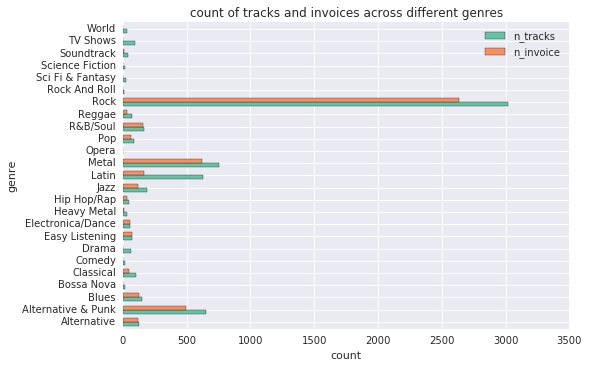

In [16]:
q7 = """
WITH genre_all AS
(
 SELECT 
     g.name genre,
     t.track_id,
     il.invoice_id
 FROM genre g 
 LEFT JOIN track t ON t.genre_id=g.genre_id
 LEFT JOIN invoice_line il ON il.track_id=t.track_id
)
SELECT
     genre,
     COUNT(track_id) n_tracks,
     COUNT(invoice_id) n_invoice
FROM genre_all
GROUP BY genre
"""
df_7=run_query(q7)

df_7=df_7.set_index('genre',drop=True)

n=len(df_7['n_tracks'])
plt.figure(figsize=(20, 50))
ax = df_7.plot(kind='barh',width=0.65,title='count of tracks and invoices across different genres',color=sns.color_palette("Set2", n))
ax.set_xlabel('count')
plt.show()


there are more tracks of Latin music than it can sell.
and there are less tracks of TV shows and Drama music than they actually sell.

task8: do protected vs non-protected media types have an effect on popularity? in other words, compare the sales records of protected and non-protected media type track.

In [19]:
q8 = """
WITH media_type_protected AS
(
 SELECT *,
     CASE
         WHEN name LIKE '%protected%' THEN 1
         ELSE 0
     END AS protected
 FROM media_type
 )
SELECT 
    mtp.protected,
    COUNT(il.invoice_id) sale_count
FROM media_type_protected mtp
LEFT JOIN track t ON t.media_type_id=mtp.media_type_id
LEFT JOIN invoice_line il ON il.track_id=t.track_id
GROUP BY 1
"""
run_query(q8)

,protected,sale_count
0,0,4315
1,1,442


unprotected media type sells more than protected media type.